# Twitter Sentiment Analysis with BERT

#### The project is about analysis of  Covid tweets with the model used being **Bert** for predicting the emotion of tweet

# Importing the libraries

In [95]:
#General purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns



import tensorflow as tf
import tensorflow.keras as keras

#Libraries for text
import os
import nltk
import emoji 
import re
import string

#Metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import TFRobertaModel
from transformers import RobertaTokenizerFast

# Loading the datasets

In [3]:
df=pd.read_csv(r"../input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin-1')
df_test=pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_test.csv")
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df.shape

(41157, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
df['TweetAt']=pd.to_datetime(df['TweetAt'])#converting to datetime coz we will be experimenting with this column

In [7]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
df['TweetAt'].max(),df['TweetAt'].min()#Checking the latest and first date of tweets

(Timestamp('2020-12-04 00:00:00'), Timestamp('2020-01-04 00:00:00'))

In [9]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)#Dropping the duplicates from the dataframe

# Tweets per day

In [10]:
tweets_per_day=df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

In [11]:
tweets_per_day.head()

,index,counts
0,01-04,630
1,02-04,954
2,03-04,810
3,03-16,656
4,03-17,1977


Text(0.5, 0, 'Date')

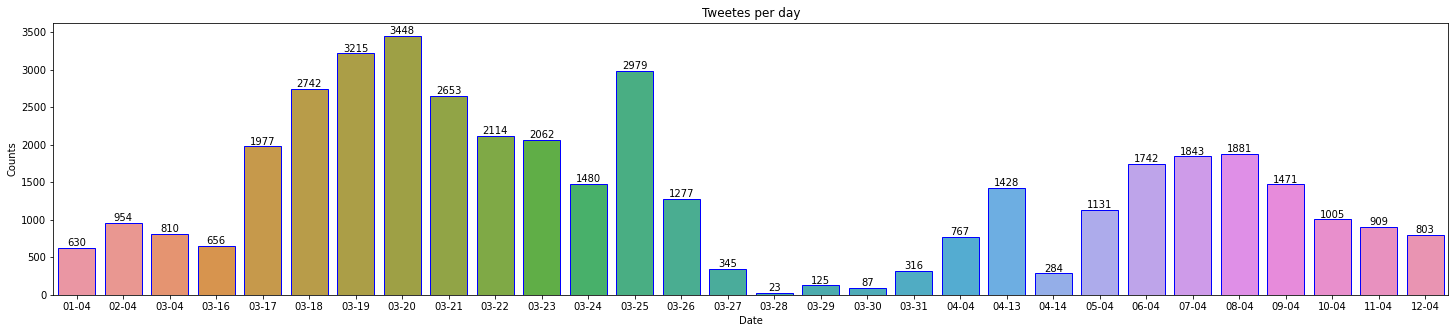

In [12]:
plt.figure(figsize=(25,5))
plt.title("Tweetes per day")
ax=sns.barplot(data=tweets_per_day,y='counts',x='index',edgecolor='blue')
ax.bar_label(ax.containers[0])
plt.ylabel('Counts')
plt.xlabel('Date')

Most of the tweets are around the end of march when covid was rising

# Tweets per country

In [13]:
df['Location'].value_counts()

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

In [14]:
tweets_per_country=df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'London'),
  Text(1, 0, 'United States'),
  Text(2, 0, 'London, England'),
  Text(3, 0, 'New York, NY'),
  Text(4, 0, 'Washington, DC'),
  Text(5, 0, 'United Kingdom'),
  Text(6, 0, 'Los Angeles, CA'),
  Text(7, 0, 'India'),
  Text(8, 0, 'UK'),
  Text(9, 0, 'Australia'),
  Text(10, 0, 'USA'),
  Text(11, 0, 'Canada'),
  Text(12, 0, 'England, United Kingdom'),
  Text(13, 0, 'Toronto, Ontario'),
  Text(14, 0, 'Global'),
  Text(15, 0, 'Chicago, IL'),
  Text(16, 0, 'California, USA'),
  Text(17, 0, 'San Francisco, CA'),
  Text(18, 0, 'Boston, MA'),
  Text(19, 0, 'New York, USA'),
  Text(20, 0, 'New Delhi, India'),
  Text(21, 0, 'Atlanta, GA'),
  Text(22, 0, 'New York'),
  Text(23, 0, 'Mumbai, India'),
  Text(24, 0, 'Worldwide')])

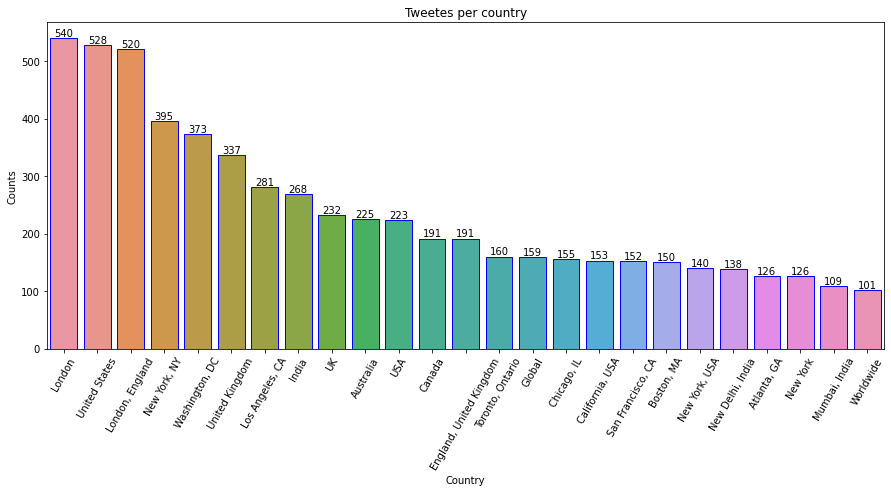

In [15]:
plt.figure(figsize=(15,6))
plt.title("Tweetes per country")
ax=sns.barplot(data=tweets_per_country,y='counts',x='index',edgecolor='blue')
ax.bar_label(ax.containers[0])
plt.ylabel('Counts')
plt.xlabel('Country')
plt.xticks(rotation=60)

#### There are some cities,some countries,and some uncommon country names in the data but this doesn't bother coz we will be considering only two columns namely 'OriginalTweet' and 'Sentiment'

In [16]:
df=df[['OriginalTweet','Sentiment']]
df_test=df_test[['OriginalTweet','Sentiment']]

Selecting the OriginalTweet and Sentiment column for our dataframe

# Deep cleaning of tweets

In [17]:
def remove_emoji(tweet):
    return re.sub(emoji.get_emoji_regexp(),r"",tweet)
#Removing the emojis because our model can't understand text so it will also not understand emojis😂

def remove_extras(tweet):
    tweet=tweet.replace('\n','').replace('\r','').replace('\n','').lower()
    tweet=re.sub(r"(?:\@|https?\://)\S+",r"",tweet)#reomve links and some mentions
    tweet=re.sub(r"[^\x00-\x7f]",r"",tweet)#removing non utf characters
    
    waste_list=string.punctuation+ 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table=str.maketrans("","",waste_list)#removes the characters in waste list
    tweet=tweet.translate(table)
    return tweet

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [18]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(remove_extras(remove_emoji(t))))))

In [19]:
texts_new[1:4]#Looking at few referenaces

['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
 'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
 'my food stock is not the only one which is emptyplease dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safecovid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral']

In [20]:
test_texts_new = []
for t in df_test.OriginalTweet:
    test_texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(remove_extras(remove_emoji(t))))))

In [21]:
test_texts_new[1:4]

['when i couldnt find hand sanitizer at fred meyer i turned to amazon but 11497 for a 2 pack of purellcheck out how coronavirus concerns are driving up prices',
 'find out how you can protect yourself and loved ones from coronavirus',
 'panic buying hits newyork city as anxious shoppers stock up on foodampmedical supplies after healthcare worker in her 30s becomes bigapple 1st confirmed coronavirus patient or a bloomberg staged event qanon2018 qanon2020 election2020 cdc']

In [22]:
df['clean_text']=texts_new
df_test['clean_text']=test_texts_new

In [23]:
df.head()

,OriginalTweet,Sentiment,clean_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


In [24]:
#Extracting the text length from tweets
text_len=[]
for text in df['clean_text']:
    x=len(text.split())
    text_len.append(x)
df['text_len']=text_len

In [25]:
test_text_len=[]
for text in df_test['clean_text']:
    x=len(text.split())
    test_text_len.append(x)
df_test['text_len']=test_text_len

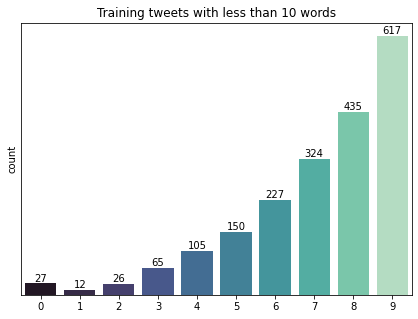

In [26]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

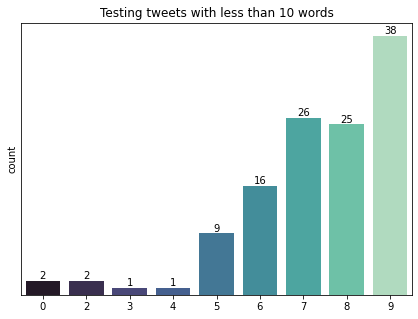

In [27]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Testing tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

Afetr the cleaning was peformed some tweets have 0 words that means those tweets were just having hashtags,links etc..So we remove them and for the purpose of modeling we take tweets with have more than 4 words

In [28]:
print(f"Train shape: {df.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (41157, 4)
Test shape: (3798, 4)


In [29]:
df = df[df['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]

In [30]:
print(f"Train shape: {df.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (40922, 4)
Test shape: (3792, 4)


# Tokenizing

In [31]:
tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
#Creating tokens for the tweets
token_lens=[]
for txt in df['clean_text'].values:
    tokens=tokenizer.encode(txt,max_length=512,truncation=True)
    token_lens.append(len(tokens))
    
max_tok_len=np.max(token_lens)

In [33]:
max_tok_len

100

In [34]:
token_lens=[]
for i,txt in enumerate(df['clean_text'].values):
    tokens=tokenizer.encode(txt,max_length=512,truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:#Checking for snetences with token length greater than 80
        print(i,txt)
    
max_tok_len=np.max(token_lens)

1621 zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
13620 hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegras que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalyacuidemosalosquecuidan
16543 bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
36941 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededir halkmz sakin olsun ve gvende hissetsin ltfen herkes evin

##### These sentence are in spanish i guess and definetly not in english so these must be dropped

In [35]:
df['token_len']=token_lens

In [36]:
df.sort_values(by='token_len',ascending=False,inplace=True)
df.head(30)

,OriginalTweet,Sentiment,clean_text,text_len,token_len
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,36,84
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,36,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,33,80
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,47,79
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79


In [37]:
df=df.iloc[12:]#removing the top Non-English language tweets

In [38]:
df.head()

,OriginalTweet,Sentiment,clean_text,text_len,token_len
26678,Eine wahre #CoronaGeschichte:\r\r\n\r\r\nWenn ...,Neutral,eine wahre coronageschichtewenn dir an der sup...,28,78
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,42,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery storewe wont get any toile...,34,76


In [39]:
df=df.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe

In [40]:
token_len_test = []

for txt in df_test['clean_text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_len_test.append(len(tokens))
    
max_len=np.max(token_len_test)

In [41]:
max_len

97

In [42]:
token_len_test = []

for i,txt in enumerate(df_test['clean_text'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_len_test.append(len(tokens))
    if len(tokens)>80:
        print(i,txt)

286 so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stocktxnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7fmy b
345 informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
2380 ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [43]:
df_test['token_len']=token_len_test

In [44]:
df_test.sort_values(by='token_len',inplace=True,ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,clean_text,text_len,token_len
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,36,97
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch facedwbhdo wash both handsgtfohg...,32,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,40,75
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take heryo mama so...,48,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [45]:
df_test=df_test[5:]
df_test.head()

,OriginalTweet,Sentiment,clean_text,text_len,token_len
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take heryo mama so...,48,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [46]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [47]:
df_test.head()

,OriginalTweet,Sentiment,clean_text,text_len,token_len
0,Went to the supermarket this morning for the r...,Neutral,went to the supermarket this morning for the r...,22,30
1,"Dunno if you e heard, but theres this thing g...",Negative,dunno if you e heard but theres this thing goi...,23,29
2,Anyone else scared of #coronavirus causing wor...,Negative,anyone else scared of coronavirus causing worl...,42,52
3,I think it's safe to say that the current situ...,Positive,i think its safe to say that the current situa...,38,41
4,Everyone panicking and buying up the grocery s...,Negative,everyone panicking and buying up the grocery s...,22,29


In [48]:
df['Sentiment'].value_counts()

Positive              11376
Negative               9887
Neutral                7554
Extremely Positive     6618
Extremely Negative     5475
Name: Sentiment, dtype: int64

In [49]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,
                                       'Positive':2,'Extremely Positive':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,
                                                 'Positive':2,'Extremely Positive':2})
#Encoding the target column

In [50]:
df_test.head()

,OriginalTweet,Sentiment,clean_text,text_len,token_len
0,Went to the supermarket this morning for the r...,1,went to the supermarket this morning for the r...,22,30
1,"Dunno if you e heard, but theres this thing g...",0,dunno if you e heard but theres this thing goi...,23,29
2,Anyone else scared of #coronavirus causing wor...,0,anyone else scared of coronavirus causing worl...,42,52
3,I think it's safe to say that the current situ...,2,i think its safe to say that the current situa...,38,41
4,Everyone panicking and buying up the grocery s...,0,everyone panicking and buying up the grocery s...,22,29


In [51]:
df.head()

,OriginalTweet,Sentiment,clean_text,text_len,token_len
0,Went to the grocery store. I suppose no more s...,0,went to the grocery store i suppose no more sm...,31,41
1,Ocado expected to impose rationing on more pro...,0,ocado expected to impose rationing on more pro...,19,36
2,Celebrity in the time of,1,celebrity in the time of,5,7
3,This is awesome! #supermarket #COVID19 #corona...,2,this is awesome supermarket covid19 coronaviru...,11,25
4,Antiplastic trends and sudden Thai government ...,1,antiplastic trends and sudden thai government ...,33,50


In [52]:
df['Sentiment'].value_counts()

2    17994
0    15362
1     7554
Name: Sentiment, dtype: int64

# Oversampling

In [53]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['clean_text']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['clean_text', 'Sentiment']);

In [56]:
train_os['Sentiment'].value_counts()#Now all the classes have equal number of samples

0    17994
1    17994
2    17994
Name: Sentiment, dtype: int64

# Train Valid Split

In [57]:
X=train_os['clean_text'].values
y=train_os['Sentiment'].values

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [59]:
X_test = df_test['clean_text'].values
y_test = df_test['Sentiment'].values

In [60]:
#We are making a copy of label encoded columns
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

# One Hot Encoding

In [61]:
import sklearn
ohe = sklearn.preprocessing.OneHotEncoder()
y_train1 = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid1 = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test1 = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

#### when target was label encoded the model was not giving high accuracy because model tends to be bias at label 2 than label 1 as expected ,So we will be using one hot encoding 

In [62]:
y_train1

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [63]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48583
VALIDATION DATA: 5399
TESTING DATA: 3787


# Bert Modelling

In [71]:
MAX_LEN=128

In [80]:
#Let's check how the encoding is performed and ids,attention masks are made
encoded_sample = tokenizer.encode_plus(
            X_train[2],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
encoded_sample

{'input_ids': [101, 2035, 2017, 18656, 2040, 2228, 26071, 2300, 2003, 1037, 4121, 9470, 2157, 2085, 2323, 5382, 2008, 2116, 2024, 6069, 2022, 8110, 2068, 2039, 2007, 11112, 2300, 1998, 4855, 2009, 2000, 2017, 2012, 10021, 7597, 3426, 1997, 1996, 15561, 10047, 2469, 2116, 2467, 2106, 21887, 23350, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [72]:
#We are tokenizing the tweets and extracting the attention masks and input masks
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [73]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [74]:
bert_model=TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-01-13 02:04:00.839296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 02:04:00.840532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 02:04:00.841327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 02:04:00.842270: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [75]:
#Creating the bert based model
def create_model(bert_model, max_len=MAX_LEN):
    
    #Parameters for compiling the models
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    #We will be building a functional api model instead of sequential with two inputs and 1 output
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')#input-1
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')#input-2
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [76]:
model_bert=create_model(bert_model,MAX_LEN)
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            2307        tf_bert_model[0][1]          

In [77]:
history_bert = model_bert.fit([train_input_ids,train_attention_masks], y_train1, validation_data=([val_input_ids,val_attention_masks], y_valid1), epochs=4, batch_size=32)

2022-01-13 02:04:15.188079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
1519/1519 [==============================] - 758s 490ms/step - loss: 0.5545 - categorical_accuracy: 0.7812 - val_loss: 0.3563 - val_categorical_accuracy: 0.8676
Epoch 2/4
1519/1519 [==============================] - 741s 488ms/step - loss: 0.3026 - categorical_accuracy: 0.8937 - val_loss: 0.2662 - val_categorical_accuracy: 0.8994
Epoch 3/4
1519/1519 [==============================] - 741s 488ms/step - loss: 0.2065 - categorical_accuracy: 0.9271 - val_loss: 0.3082 - val_categorical_accuracy: 0.8950
Epoch 4/4
1519/1519 [==============================] - 741s 488ms/step - loss: 0.1427 - categorical_accuracy: 0.9522 - val_loss: 0.2353 - val_categorical_accuracy: 0.9255


# Results

In [78]:
bert_pred=model_bert.predict([test_input_ids,test_attention_masks])

In [81]:
bert_pred

array([[1.9520568e-03, 9.9308020e-01, 4.9677100e-03],
       [9.9497074e-01, 3.0806472e-03, 1.9486041e-03],
       [9.6743339e-01, 1.1257712e-02, 2.1308839e-02],
       ...,
       [9.9908555e-01, 2.4291220e-04, 6.7148864e-04],
       [1.7819270e-04, 1.6453057e-04, 9.9965727e-01],
       [7.8710109e-05, 4.8548343e-05, 9.9987268e-01]], dtype=float32)

In [84]:
y_test1

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [100]:
y_pred=[]
for i in tqdm(bert_pred):
    pred=np.argmax(i)
    y_pred.append(pred)

100%|██████████| 3787/3787 [00:00<00:00, 226046.41it/s]


In [102]:
y_pred[:5]

[1, 0, 0, 2, 0]

In [103]:
y_test[:5]

array([1, 0, 0, 2, 0])

In [104]:
confusion_matrix(y_test,y_pred)

array([[1442,   54,  133],
       [  59,  491,   64],
       [  83,   38, 1423]])

In [108]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

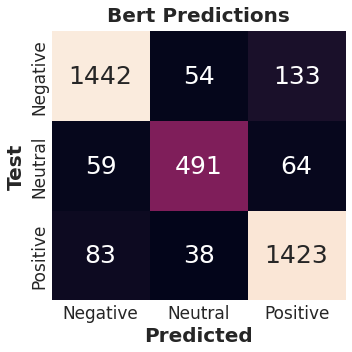

In [109]:
conf_matrix(y_test,y_pred,'Bert Predictions')